## Portfolio 5: Predicting Airbnb Listing Prices in Melbourne

## <u>1. Problem Description and Initial Data Analysis</u>


### Forecasting Problem


The project aims to accurately predict Melbourne Airbnb listings prices via machine-learning models, despite challenges arising from external factors, varying listing features, and incomplete data. Data preprocessing is employed to extract essential information and eliminate irrelevant features, ensuring effective model performance and reliable price predictions. This project benefits customers by preventing overcharging, increasing satisfaction, and enabling hosts to establish competitive prices based on the unique features of their Airbnb listings.


### Evaluation Criteria


The evaluation metric utilised for this project is Root Mean Squared Error (RMSE). It is computed by summing the squared differences between predicted and actual prices, dividing by the total number of listings, and taking the square root. The equation for RMSE appears as below:


$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ( \hat{y}_i - y_i)^2}
$$


Where:
- \(n\): the total number of listings.
- \(y_i\): the actual price of the \(i\)th listing.
- \(\hat{y}_i\): the predicted price of the \(i\)th listing provided by the model.


RMSE serves as a sensitive evaluation metric, with lower values indicating more accurate price predictions. Thus, it facilitates model performance comparison.


### Types of Variables/Features


The dataframe comprises various data types, including:


Numerical features:
- Continuous: 'host_response_rate', 'latitude', 'price'. These represent values that can take any numeric value within a continuous range.
- Discrete: 'calculated_host_listings_count' , 'accommodates'. These values are measured in whole numbers.


Categorical features:
- Nominal variables: 'host_is_superhost', 'instant_bookable', 'property_type'. These represent categorical variables that have no inherent order and contain multiple distinct values that are mutually exclusive.
- Ordinal variable: 'host_response_time', 'review_scores_rating'. These variables exhibit an ordered or ranked nature.


Date features: 'host_since', 'first_review', 'last_review'. These signify dates with details of the year, month, and day.


In section 2, categorical and date variables are encoded as numerical features to ensure compatibility with machine learning algorithms while preserving data meaning.


### Data Summary and Main Data Characteristics


The dataset includes a training set (7000 entries, 61 variables) with the target variable 'price' containing outliers, and a test set (3000 observations, 60 variables), excluding the 'price' variable. It encompasses diverse categorical and numerical features, necessitating extraction, feature engineering, and encoding techniques. Additionally, irrelevant textual features such as host-related columns, names, and ID are eliminated to reduce computational load. Furthermore, variables exhibiting robust correlations, particularly associated with availabilities and nights, are removed to address multicollinearity. Feature aggregation is also employed to simplify average review score computation and exclude redundant columns. Moreover, imputations are conducted on specific features to handle outliers exhibiting significant skewness. These pre-processing steps effectively prepare the dataset for subsequent analysis and predictive tasks.


### Missing Values


Both datasets exhibit a significant number of missing values across various features, with notable proportions ranging from 26.04% to 49.43% in the training set and 47.47% to 68.87% in the testing set for features like 'host_neighbourhood', 'host_about', 'neighborhood_overview', and 'neighbourhood'. Minor occurrences of missing values are also observed in other variables such as 'bedrooms', 'room_type', and 'neighbourhood_cleansed'. Hence, appropriate imputation methods or removing instances with missing values is crucial to generate reliable predictions. Additionally, training set statistics are utilised to impute the test set missing values to prevent data leakage.


---
## <u>2. Data Cleaning, Missing Observations and Feature Engineering</u>

In [16]:
# ============================================================================
#                               Importing Libraries
# ============================================================================

from pandas import read_csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
pd.set_option('display.max_columns',None)

# Suppress warnings to maintain a clean output
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
# ============================================================================
#             Loading Data and Displaying the Shape of the Dataset
# ============================================================================

# Load the train and test datasets
train_df = read_csv('train.csv')
test_df = read_csv('test.csv')

# Display the shapes of the datasets to provide an understanding of the data size
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (7000, 61)
Test data shape: (3000, 60)


## Section 2.1: Numerical Feature Extraction and Processing

### Subsection 2.1.1 : Extraction and Cleaning of Numerical Features

`extract_and_clean_numerical_features()`:

- Converts certain columns to datetime format.
- Calculates days elapsed from reference date.
- Cleans 'price' and removes original date columns.
- Applied to both training and testing DataFrames.

In [18]:
def extract_and_clean_numerical_features(df):
    """
    Extracts and cleans numerical features in a DataFrame for better processing by training algorithms.
    
    This function specifically cleans 'host_response_rate', 'host_acceptance_rate', 
    'bathrooms', 'price', and 'host_since' columns. It also creates new columns capturing 
    years, months and days elapsed from date columns and drops the original date columns.
    
    Args:
        df (pd.DataFrame): DataFrame containing the numerical features to be cleaned.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame with processed numerical features.
    """
    # Your existing code

    # Convert 'host_since', 'first_review', and 'last_review' columns to datetime format
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['last_review'] = pd.to_datetime(df['last_review'])

    
    # Define the reference date
    reference_date = pd.Timestamp('2023-05-28')

    # Calculate days elapsed from date columns and create new columns
    df['days_since_host'] = (reference_date - df['host_since']).dt.days

    df['days_since_first_review'] = (reference_date - df['first_review']).dt.days
    df['days_since_last_review'] = (reference_date - df['last_review']).dt.days
    
    # If the DataFrame has a 'price' column, we clean it by removing '$' and ',' characters, and convert the column to float
    if 'price' in df.columns:
        df['price'] = df['price'].str.replace('[\$,]', '', regex=True).astype(float)

    # Drop original date columns as we've captured the necessary information in the new columns
    df.drop('host_since', axis=1, inplace=True)
    df.drop('first_review', axis=1, inplace=True)
    df.drop('last_review', axis=1, inplace=True)
    
    # Your existing code

    return df # Return the cleaned DataFrame

# ============================================================================
#                    Applying extraction and cleaning function to DataFrames
# ============================================================================
train_df = extract_and_clean_numerical_features(train_df)
test_df = extract_and_clean_numerical_features(test_df)


### Subsection 2.1.2 : Bathroom Feature Extraction

`extract_bath_features()`:

- Handles missing values and extracts numerical data from 'bathrooms'.
- Creates binary columns for bathroom types and removes the original column.
- Applied to both training and testing DataFrames.


In [19]:
def extract_bath_features(df):
    # Create a copy to avoid changing the original dataframe
    df = df.copy()

    # Fill NaN values with a specific string
    df['bathrooms'] = df['bathrooms'].fillna('unknown')

    # Numerical bathrooms
    df['num_bathrooms'] = df['bathrooms'].apply(lambda x: 0.5 if 'half' in x.lower() 
                                               else float(x.split()[0]) if 'unknown' not in x and isinstance(x, str) 
                                               else np.nan)

    # Impute NaN in 'num_bathrooms' with the median value
    df['num_bathrooms'] = df['num_bathrooms'].fillna(df['num_bathrooms'].median())

    # Bathroom type
    df['is_shared_bathroom'] = 0
    df['is_private_bathroom'] = 0
    df.loc[df['bathrooms'].str.contains('shared'), 'is_shared_bathroom'] = 1
    df.loc[~df['bathrooms'].str.contains('shared'), 'is_private_bathroom'] = 1
    
    # Drop original date columns as we've captured the necessary information in the new columns
    df.drop('bathrooms', axis=1, inplace=True)
    return df

train_df = extract_bath_features(train_df)
test_df = extract_bath_features(test_df)


---

## Section 2.2: Feature Engineering and Extraction

### Subsection 2.2.1 : Host Verification Processing

The function `process_host_verifications()`:

- Initializes new columns for 'email', 'phone', and 'work_email'.
- Populates these columns based on the presence of these verifications in 'host_verifications'.
- Creates 'num_of_verification' to count total verifications.
- Removes the original 'host_verifications' column.
- Applied to both training and testing DataFrames.

In [20]:
def process_host_verifications(df):
    '''
    This function processes the 'host_verifications' and 'amenities' columns in the dataframe.
    It creates new columns ('email', 'phone', 'work_email') indicating the presence of these verifications.
    It also creates a 'num_of_verification' column to represent the total number of verifications.
    Lastly, it processes the 'amenities' column and creates a 'num_amenities' column.
    '''
    # Initialize new columns
    for col in ['email', 'phone', 'work_email']:
        df[col] = 0
    
    # Update the new columns based on host_verifications
    for i, row in df.iterrows():
        verifications = row['host_verifications']
        for col in ['email', 'phone', 'work_email']:
            if col in verifications:
                df.at[i, col] = 1

    # Create new column for number of verifications
    df['num_of_verification'] = df.loc[:, ['email', 'phone', 'work_email']].sum(axis=1)
    
    # Drop original date columns as we've captured the necessary information in the new columns
    df.drop('host_verifications', axis=1, inplace=True)
    
    return df


# Apply the function to both train and test DataFrames
train_df = process_host_verifications(train_df)
test_df = process_host_verifications(test_df)


### Subsection 2.2.3 : Calculation of Haversine Distance to Landmarks

This code calculates distances from various landmarks to locations in our datasets (train_df and test_df). We first define a function `haversine` that calculates the distance between two points on Earth. Then we create a list of landmarks with their coordinates.

The code then calculates the distance from each location in our datasets to each landmark, creating a new data column for each landmark's distance. By incorporating these distances into our data, we add valuable geographic context that could help us better understand patterns in rental prices and demand. We might find, for instance, that proximity to certain landmarks is consistently associated with higher or lower rental prices. Such insights could be highly useful in our subsequent analysis or machine learning tasks.This adds useful geographic context to our data, which could be helpful for later analysis or machine learning tasks.

In [21]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

landmarks = {
    'melbourne_cbd': [-37.8136, 144.9631],
    'st_kilda_beach': [-37.8676, 144.9740],
    'melbourne_cricket_ground': [-37.8197, 144.9834],
    'university_of_melbourne': [-37.7963, 144.9614],
    'rmit_university': [-37.8075, 144.9633],
    'melbourne_zoo': [-37.7833, 144.9514],
    'yarra_valley': [-37.6508, 145.5171],
}

for landmark, coordinates in landmarks.items():
    train_df[f'distance_to_{landmark}'] = train_df.apply(lambda row: haversine(row['longitude'], row['latitude'], coordinates[1], coordinates[0]), axis=1)
    test_df[f'distance_to_{landmark}'] = test_df.apply(lambda row: haversine(row['longitude'], row['latitude'], coordinates[1], coordinates[0]), axis=1)

### Subsection 2.2.3 : Exploring Amenities for Price Prediction

Understanding property amenities is crucial for predicting Airbnb prices, as they significantly impact guest experience and the price a host can charge. The Python function `add_amenity_features()` streamlines and enhances the amenities data by identifying key amenities in each listing, making it easy for a machine learning model to interpret.

This function creates additional features to quantify the total number of amenities and key amenities offered by each property. It helps the model understand how the combination and count of amenities relate to the listing price.

In [22]:
def add_amenity_features(df):
    """
    This function adds new amenity features to the given DataFrame 'df' and creates two new columns: 
    'sum_of_key_amenities' and 'n_amenities'.
    """

    # Define the list of new features
    new_features = ['has_air_conditioning', 'has_BBQ', 'has_nature_view', 'includes_breakfast', 
                    'has_cooking_basics', 'has_home_appliances', 'has_gym', 'is_child_friendly', 
                    'has_parking', 'has_outdoor_space', 'has_pool_or_spa']

    # Map amenities to new features
    amenities_to_features = {
        'Air conditioning|Central air conditioning': 'has_air_conditioning',
        'BBQ grill|Fire pit|Propane barbeque': 'has_BBQ',
        'Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront': 'has_nature_view',
        'Breakfast': 'includes_breakfast',
        'Cooking basics': 'has_cooking_basics',
        'Dishwasher|Dryer|Washer': 'has_home_appliances',
        'Exercise equipment|Gym|gym': 'has_gym',
        'Family/kid friendly|Children|children': 'is_child_friendly',
        'parking': 'has_parking',
        'Garden|Outdoor|Sun loungers|Terrace|Balcony|Patio': 'has_outdoor_space',
        'Hot tub|Jetted tub|hot tub|Sauna|Pool|pool': 'has_pool_or_spa'
    }

    # Create new features based on amenities
    for amenities, feature in amenities_to_features.items():
        df.loc[df['amenities'].str.contains(amenities), feature] = 1

    # Replace nulls with zeros for new features and change data type to int
    df[new_features] = df[new_features].fillna(0)
    df[new_features] = df[new_features].astype(int)

    # Calculate the total number of key amenities
    df['sum_of_key_amenities'] = df[new_features].sum(axis=1)

    # Count the number of amenities and add it to the n_amenities column
    df['n_amenities'] = df['amenities'].apply(lambda x: len(x.replace('{', '').replace('{', '').\
                                                                    replace('"', '').split(',')))

    # Drop the amenities columns after encoding
    df = df.drop(['amenities'], axis=1)

    return df

# Add amenity features to train dataset
train_df = add_amenity_features(train_df)

# Add the same amenity features to test dataset
test_df = add_amenity_features(test_df)


### Subsection 2.2.4 : Data Simplification: Removing Multicollinearity and Redundancy


By removing multicollinearity through the `remove_multicollinearity(df)` function, we not only enhance model performance and accuracy, but also reduce the dimensionality of the data. This simplifies the model, making it easier to understand and faster to process. 

Additionally, visualizing multicollinear variables provides valuable insights into the relationships within the data. This enhances our understanding of the potential impacts these relationships can have on our predictive models. With this understanding, we are better equipped to interpret the output of the model, and can more effectively communicate the implications of the model's predictions. 

This combination of removal and visualization of multicollinearity thus serves to both simplify our dataset and to deepen our comprehension of its underlying structure.

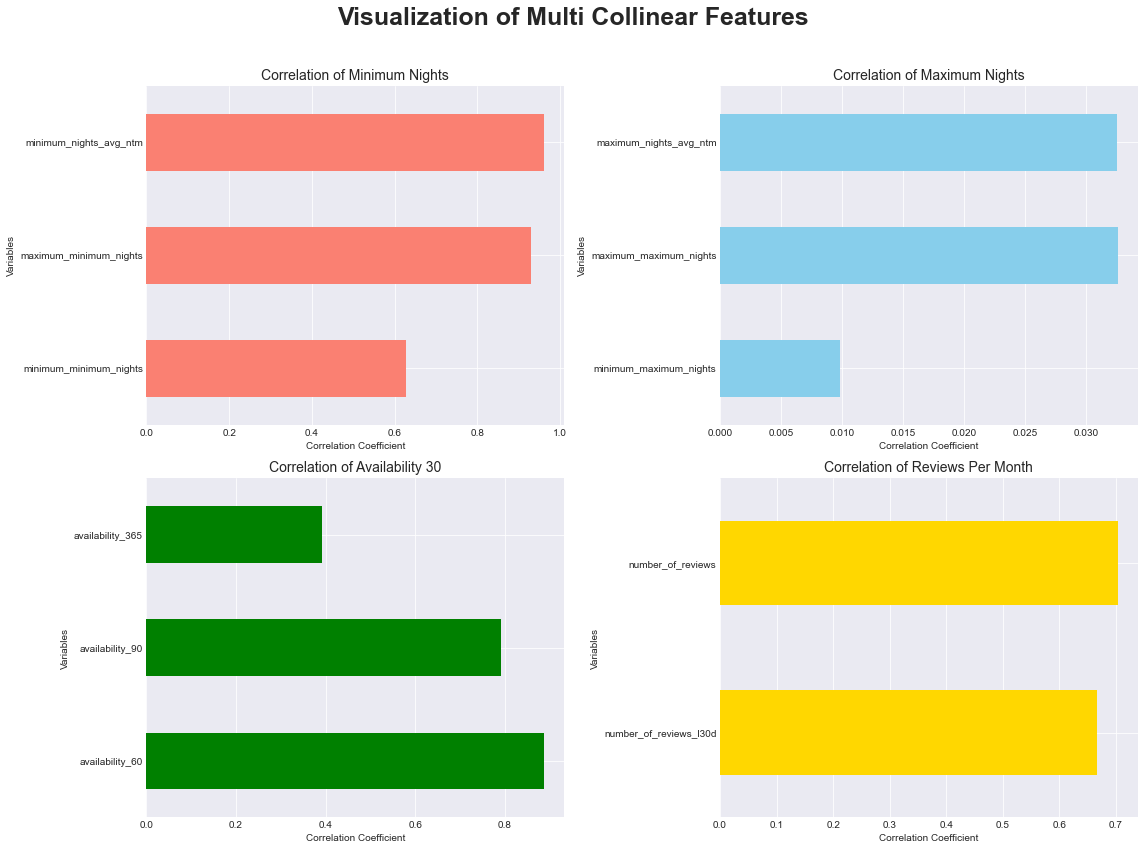

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')  # use seaborn-darkgrid style

# Assuming train_df is your DataFrame
minimum_nights_corr = train_df[['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_nights_avg_ntm', 'minimum_nights']].corr().loc['minimum_nights']
maximum_nights_corr = train_df[['minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'maximum_nights']].corr().loc['maximum_nights']
availability_corr = train_df[['availability_30','availability_60', 'availability_90', 'availability_365']].corr().loc['availability_30']
reviews_corr = train_df[['reviews_per_month', 'number_of_reviews_l30d', 'number_of_reviews']].corr().loc['reviews_per_month']

# Converting the Series to DataFrame for better visualization
df_corr_min_nights = minimum_nights_corr.to_frame('correlation')
df_corr_max_nights = maximum_nights_corr.to_frame('correlation')
df_corr_availability = availability_corr.to_frame('correlation')
df_corr_reviews = reviews_corr.to_frame('correlation')

# Setting up the subplots
fig, axes = plt.subplots(2, 2, figsize=(16,12))

# Plotting the data with different colors
df_corr_min_nights.drop('minimum_nights').plot(kind='barh', legend=False, ax=axes[0,0], color='salmon')
df_corr_max_nights.drop('maximum_nights').plot(kind='barh', legend=False, ax=axes[0,1], color='skyblue')
df_corr_availability.drop('availability_30').plot(kind='barh', legend=False, ax=axes[1,0], color='green')
df_corr_reviews.drop('reviews_per_month').plot(kind='barh', legend=False, ax=axes[1,1], color='gold')

# Setting the titles
axes[0,0].set_title('Correlation of Minimum Nights', fontsize=14)
axes[0,1].set_title('Correlation of Maximum Nights', fontsize=14)
axes[1,0].set_title('Correlation of Availability 30', fontsize=14)
axes[1,1].set_title('Correlation of Reviews Per Month', fontsize=14)

# Setting the labels
for ax in axes.flat:
    ax.set(xlabel='Correlation Coefficient', ylabel='Variables')

# Setting the title for the entire figure
plt.suptitle('Visualization of Multi Collinear Features', fontsize=25,fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust the tight_layout so the title doesn't overlap with the top subplot
plt.show()

In [24]:
def remove_multicollinearity(df):
    '''
    This function removes features from the input DataFrame that are highly correlated, 
    in order to reduce multicollinearity.
    '''
    # List of highly correlated features related to nights, keeping 'minimum_nights' and 'maximum_nights'
    nights_cols_to_drop = ['minimum_minimum_nights', 'maximum_minimum_nights', 
                           'minimum_maximum_nights', 'maximum_maximum_nights', 
                           'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
    
    # List of highly correlated features related to availability, keeping 'availability_30'
    availability_cols_to_drop = ['availability_60', 'availability_90', 'availability_365']
    
    # List of highly correlated features related to reviews, keeping 'number_of_reviews_ltm'
    review_cols_to_drop = ['reviews_per_month', 'number_of_reviews_l30d', 'number_of_reviews']

    # Combine all lists of features to drop
    cols_to_drop = nights_cols_to_drop + availability_cols_to_drop + review_cols_to_drop

    # Drop columns from DataFrame
    df = df.drop(cols_to_drop, axis=1)

    return df

# Apply the function to both train and test DataFrames
train_df = remove_multicollinearity(train_df)
test_df = remove_multicollinearity(test_df)

---
## Section 2.3: Enhancing Data Quality: Imputing Missing Values

The function `display_missing_data_info(train_df, test_df)` is called to display the missing values in the `train_df` and `test_df` datasets. This analysis helps us identify any missing data points and assess the extent of missingness in our data.

Imputing missing values is a critical step in improving data quality. In this section, we will explore various methods and techniques to handle missing values effectively, ensuring a more complete and reliable dataset for further analysis and modeling.

In [25]:
# ============================================================================
#                    Checking for Missing Data Values
# ============================================================================

def display_missing_data_info(train_df, test_df):
    """
    This function calculates and displays missing data information in a DataFrame format.
    It only shows rows where 'Train Total' or 'Test Total' is greater than 0.
    """
    # Function to calculate missing values in a dataset
    def calculate_missing_values(df):
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum() / df.isnull().count() * 100).round(2).astype(str) + '%'
        return total, percent

    # Calculate missing values in train and test data
    train_total, train_percent = calculate_missing_values(train_df)
    test_total, test_percent = calculate_missing_values(test_df)

    # Combine the missing data information into a single dataframe for easy comparison
    missing_info = pd.concat([train_total, train_percent, test_total, test_percent], 
                             axis=1, keys=['Train Total', 'Train Percent','Test Total','Test Percent'])
    
    # Filter the dataframe to only include rows where 'Train Total' or 'Test Total' is greater than 0
    missing_info = missing_info[(missing_info['Train Total'] > 0) | (missing_info['Test Total'] > 0)]
    
    return missing_info

In [26]:
# Call the function and display the resulting DataFrame
missing_values_overview = display_missing_data_info(train_df, test_df)
missing_values_overview.head(10)

,Train Total,Train Percent,Test Total,Test Percent
host_neighbourhood,3460,49.43%,2066.0,68.87%
host_about,2270,32.43%,1441.0,48.03%
neighborhood_overview,1823,26.04%,1424.0,47.47%
neighbourhood,1823,26.04%,1424.0,47.47%
host_location,1280,18.29%,770.0,25.67%
bedrooms,378,5.4%,60.0,2.0%
room_type,134,1.91%,41.0,1.37%
neighbourhood_cleansed,108,1.54%,42.0,1.4%
property_type,84,1.2%,39.0,1.3%
beds,72,1.03%,12.0,0.4%


**Visualizing the Top 5 Features with the Most Missing Data:**

The function `plot_missing_values()` generates a barplot displaying the top 5 features with the most missing values in both the training and testing datasets.

This visualization provides a clear and concise way to understand the extent of missing data. It shows us how much data is missing in each of the top 5 features and lets us compare the proportion of missing data between the training and testing datasets for each of these features. This could help guide our strategies for handling missing data during the data preprocessing stage.

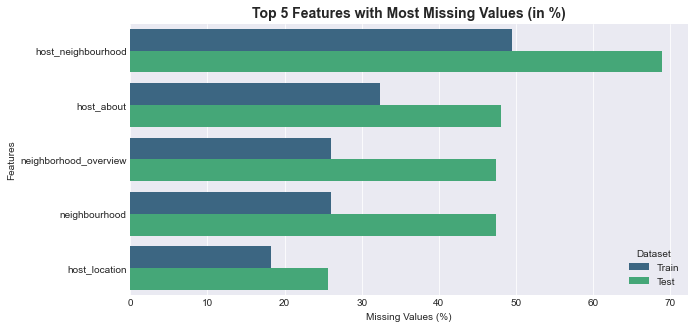

In [27]:
def plot_missing_values(missing_values_overview):
    """
    This function generates a barplot of the top 5 features with the most missing values in both 
    the training and testing datasets.

    Args:
        missing_values_overview (pd.DataFrame): DataFrame that contains information about missing values.

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Select top 5 features with most missing values
    top_missing = missing_values_overview.sort_values(by='Train Total', ascending=False).head(5)

    # Convert percentage columns to float for plotting
    top_missing['Train Percent'] = top_missing['Train Percent'].str.replace('%', '').astype(float)
    top_missing['Test Percent'] = top_missing['Test Percent'].str.replace('%', '').astype(float)

    # Prepare data for seaborn plotting
    top_missing_melted = top_missing[['Train Percent', 'Test Percent']].reset_index().melt(id_vars='index', var_name='Dataset', value_name='Missing Percent')

    # Replace column names for pretty printing
    top_missing_melted.replace({'Train Percent': 'Train', 'Test Percent': 'Test'}, inplace=True)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Missing Percent', y='index', hue='Dataset', data=top_missing_melted, palette='viridis')
    plt.title('Top 5 Features with Most Missing Values (in %)', fontsize=14, fontweight='bold')
    plt.xlabel('Missing Values (%)')
    plt.ylabel('Features')
    plt.show()

# Call the function
plot_missing_values(missing_values_overview)

### Subsection 2.3.1 : Data Refinement and Reduction

The `refine_and_reduce_data(df)` function performs two main tasks for data cleaning and simplification. It refines the neighborhood data by renaming the neighbourhood_cleansed column to local_government_area and replacing any null values with 'Unknown'. Additionally, it reduces the dimensionality of the data by dropping less informative columns. Applying this function to the data aids in streamlining the dataset for more effective analysis.

In [28]:
def refine_and_reduce_data(df):
    """
    This function renames the 'neighbourhood_cleansed' column to 'local_government_area',
    fills any null values with 'Unknown', and removes less informative columns.
    """
    # Rename the column
    df = df.rename(columns={'neighbourhood_cleansed': 'local_government_area'})
    
    # Fill null values with 'Unknown'
    df['local_government_area'] = df['local_government_area'].fillna('Unknown')
    
    # Define the list of columns to be dropped
    drop_columns = ['ID','name', 'description', 'neighborhood_overview', 'host_about',
                    'neighbourhood', 'host_neighbourhood', 'host_name',
                    'host_location','has_availability']

    # Drop the columns from the DataFrame
    df = df.drop(drop_columns, axis=1)

    return df

# Apply the function to both train and test DataFrames
train_df = refine_and_reduce_data(train_df)
test_df = refine_and_reduce_data(test_df)

### Subsection 2.3.2 : **Data Uniformity: Converting Rates to Scores**

The function `convert_rates_to_scores(df)` standardizes the rating system in the dataset by converting rate columns (like host response rate and host acceptance rate) into scores out of 5. This aligns with the review scores system and maintains consistency across the dataset. It first removes the '%' sign and converts the rates into floats. Then, it rescales the rates to a score out of 5. This function is applied to both training and testing datasets, enhancing comparability of all score-based features.

In [29]:
def convert_rates_to_scores(df):
    '''
    This function converts rate columns into scores out of 5, maintaining uniformity with review scores.
    It takes as input a DataFrame and returns the DataFrame with modified rate columns.
    '''
    # List of columns to be converted
    rate_cols = ['host_response_rate', 'host_acceptance_rate']

    # Remove the '%' sign and convert rates to float
    for col in rate_cols:
        df[col] = df[col].str.replace('%', '').astype(float)

    # Convert rates into scores out of 5
    for col in rate_cols:
        df[col] = ((df[col])/100)*5

    return df

# Apply the function to both train and test DataFrames
train_df = convert_rates_to_scores(train_df)
test_df = convert_rates_to_scores(test_df)

### Subsection 2.3.3 : **Missing Value Imputation for Categorical and Numerical Variables**
The `impute_missing_values(df, reference_df=None)` function replaces missing values in the dataset (df) using appropriate methods for each column. Categorical columns are imputed with the mode (most common value), while numerical columns are imputed with the median, which is less affected by extreme values.

When a reference dataset (reference_df) is provided, it guides the imputation process. If no reference dataset is provided, the function relies on the dataset itself as a reference.

Importantly, when imputing missing values for the test dataset (test_df), the imputation is based on the median or mode derived from the training dataset (train_df). This ensures consistency, prevents data leakage, and maintains the relationship between variables learned from the training data.

By accurately filling in missing values, this function enhances the completeness and reliability of the dataset for subsequent analysis and modeling. It minimizes the impact of missing values on the overall analysis while preserving the integrity of the imputation process and the appropriate relationship between the training and test datasets.

In [30]:
def impute_missing_values(df, reference_df=None):
    """
    This function imputes missing values in the dataframe 'df' based on the 'reference_df'. 
    If 'reference_df' is not provided, 'df' is used as the reference.
    The imputation method (mode, median, mean) depends on the nature of each specific column.
    """
    # If no reference DataFrame is provided, use df itself
    reference_df = df if reference_df is None else reference_df

    # Define columns to impute and the method for each
    columns_to_impute = [
        ('host_response_time', 'mode'),
        ('host_response_rate', 'median'),
        ('host_acceptance_rate', 'median'),
        ('host_is_superhost', 'mode'),
        ('property_type', 'mode'),
        ('room_type', 'mode'),
        ('num_bathrooms', 'median'),
        ('bedrooms', 'median'),
        ('beds', 'median'),
        ('review_scores_rating', 'median'),
        ('review_scores_accuracy', 'median'),
        ('review_scores_cleanliness', 'median'),
        ('review_scores_checkin', 'median'),
        ('review_scores_communication', 'median'),
        ('review_scores_location', 'median'),
        ('review_scores_value', 'median'),
        ('days_since_first_review', 'median'),
        ('days_since_last_review', 'median')
    ]

    # Impute missing values based on the method defined
    for column, method in columns_to_impute:
        if method == 'median':
            df[column].fillna(reference_df[column].median(), inplace=True)
        elif method == 'mode':
            df[column].fillna(reference_df[column].mode()[0], inplace=True)
    return df

# Impute missing values for train dataset
train_df = impute_missing_values(train_df)

# Impute missing values for test dataset using train dataset as reference
test_df = impute_missing_values(test_df, train_df)


### Subsection 2.3.4 : **Feature Aggregation and Dimentionality Reduction**

The `calculate_average_review_and_drop` function calculates the average of the review scores, adds it as a new column to the DataFrame, and drops the original review score columns. It simplifies the process of obtaining the average review score and removes redundant columns. By calculating the average review score and removing the original review score columns, this function simplifies the dataset while retaining valuable information. It aggregates the review scores and reduces the dimensions, making the data more manageable and suitable for further analysis or modeling tasks.

In [31]:
def calculate_average_review_and_drop(df):
    '''
    This function calculates the average of the review scores, adds it as a new column to the DataFrame,
    and drops the original review score columns.
    '''
    review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                   'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                   'review_scores_value']

    df['average_review'] = df[review_cols].mean(axis=1)
    
    # Drop original review columns
    df = df.drop(columns=review_cols)

    return df

# Apply the function to both train and test DataFrames
train_df = calculate_average_review_and_drop(train_df)
test_df = calculate_average_review_and_drop(test_df)


---
## Section 2.4: Categorical Variable Encoding: Overview and Approach

The purpose of encoding categorical variables for machine learning is to convert non-numeric data into numerical representations that can be understood and processed by machine learning algorithms. This helps prepare the dataset so that we can feed it to regression models in order to predict Airbnb prices. Encoding ensures that all variables are in a compatible format for the regression models to effectively learn patterns and make accurate price predictions.


### Subsection 2.4.1 : **Encoding Nominal Features Using One-Hot Encoding**

**Nominal features** are encoded using **one-hot encoding** to represent each category as a binary column. This approach creates a separate binary column for each unique category, with a value of 1 indicating the presence of that category and 0 otherwise. One-hot encoding is used for nominal features because it ensures that all categories are treated equally and avoids introducing any artificial ordinal relationships. It allows machine learning algorithms to appropriately interpret and utilize the categorical information, without assuming any numerical relationship between the categories.

**1. Encoding local_government_area:**

The `encode_local_government_area` function encodes the categorical variable 'local_government_area' in the train and test dataframes using one-hot encoding. It replaces values other than the top 5 local government areas with 'Others' to reduce the dimensionality. The function then performs one-hot encoding on the 'local_government_area' column, creating new binary columns for each unique value. The encoded columns are concatenated with the original dataframes, and the 'local_government_area' column is dropped. The function returns the encoded train and test dataframes.

In [32]:
def encode_local_government_area(train_df, test_df):
    """
    Encodes the 'local_government_area' categorical variable in the train and test dataframes by applying
    one-hot encoding.

    Args:
        train_df (pandas.DataFrame): Train dataframe.
        test_df (pandas.DataFrame): Test dataframe.

    Returns:
        tuple: A tuple containing the encoded train and test dataframes.
    """
    top_local_gov_area = ['Melbourne', 'Port Phillip', 'Yarra Ranges', 'Yarra', 'Stonnington']

    # Replace values other than the top 5 local_government_area with 'Others'
    train_df['local_government_area'] = train_df['local_government_area'].where(
        train_df['local_government_area'].isin(top_local_gov_area), 'Others')
    test_df['local_government_area'] = test_df['local_government_area'].where(
        test_df['local_government_area'].isin(top_local_gov_area), 'Others')

    # One-hot encoding the local_government_area column
    train_encoded = pd.get_dummies(train_df['local_government_area'], prefix='local_government_area')
    test_encoded = pd.get_dummies(test_df['local_government_area'], prefix='local_government_area')

    # Concatenate the encoded columns to the original dataframes
    train_df = pd.concat([train_df, train_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)

    # Drop the 'local_government_area' column after encoding
    train_df = train_df.drop(['local_government_area'], axis=1)
    test_df = test_df.drop(['local_government_area'], axis=1)

    return train_df, test_df

# Call the function
train_df, test_df = encode_local_government_area(train_df, test_df)


**2. Encoding property_type:**

The `encode_property_type` function applies one-hot encoding to the 'property_type' categorical variable in the train and test dataframes. It replaces non-top property types with 'OtherPropertyType', performs one-hot encoding, concatenates the encoded columns, and drops the original 'property_type' column. The function returns the encoded train and test dataframes. This function shares similarities with the previous encoding function but focuses on a different categorical variable.

In [33]:
def encode_property_type(train_df, test_df):
    """
    Encodes the 'property_type' categorical variable in the train and test dataframes by applying
    one-hot encoding.

    Args:
        train_df (pandas.DataFrame): Train dataframe.
        test_df (pandas.DataFrame): Test dataframe.

    Returns:
        tuple: A tuple containing the encoded train and test dataframes.
    """
    top_property_types = ['Entire rental unit', 'Entire home', 'Private room in home', 
                          'Entire serviced apartment','Entire guesthouse']

    # Replace values other than the top 4 property_type with 'OtherPropertyType'
    train_df['property_type'] = np.where(train_df['property_type'].isin(top_property_types),
                                         train_df['property_type'], 'OtherPropertyType')
    test_df['property_type'] = np.where(test_df['property_type'].isin(top_property_types),
                                        test_df['property_type'], 'OtherPropertyType')

    # One-hot encoding the property_type column
    train_encoded = pd.get_dummies(train_df['property_type'], prefix='property_type')
    test_encoded = pd.get_dummies(test_df['property_type'], prefix='property_type')

    # Concatenate the encoded columns to the original dataframes
    train_df = pd.concat([train_df, train_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)

    # Drop the 'property_type' column after encoding
    train_df = train_df.drop(['property_type'], axis=1)
    test_df = test_df.drop(['property_type'], axis=1)

    return train_df, test_df

# Call the function
train_df, test_df = encode_property_type(train_df, test_df)


**3. Encoding room_type:**

Similar to the encoding techniques used for ***local_government_area*** and ***property_type*** features, we apply the same approach to encode the ***room_type*** feature. Since there are only four values, there is no need to group them and create an "others" column. The encode_room_type function is responsible for encoding this feature.


In [34]:
def encode_room_type(train_df, test_df):
    """
    Encodes the 'room_type' categorical variable in the train and test dataframes by applying
    one-hot encoding.

    Args:
        train_df (pandas.DataFrame): Train dataframe.
        test_df (pandas.DataFrame): Test dataframe.

    Returns:
        tuple: A tuple containing the encoded train and test dataframes.
    """
    # One-hot encoding the room_type column
    train_encoded = pd.get_dummies(train_df['room_type'], prefix='room_type')
    test_encoded = pd.get_dummies(test_df['room_type'], prefix='room_type')

    # Concatenate the encoded columns to the original dataframes
    train_df = pd.concat([train_df, train_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)

    # Drop the 'room_type' column after encoding
    train_df = train_df.drop(['room_type'], axis=1)
    test_df = test_df.drop(['room_type'], axis=1)

    return train_df, test_df

# Call the function
train_df, test_df = encode_room_type(train_df, test_df)


### Subsection 2.4.2 : **Encoding Binary or Ordinal Features Using Label Encoding**

**Binary** and **ordinal** variables are handled using label encoding because it assigns numerical labels to represent the categories, preserving the order and allowing models to interpret the variables as continuous or ordinal scales. This enables machine learning algorithms to process and learn from these variables effectively.

The `label_encoding` function encodes categorical variables in the train and test dataframes using label encoding. It applies label encoding to selected variables and maps specific values to numerical representations. The function returns the encoded train and test dataframes.

In [35]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(train_df, test_df):
    """
    Encodes the categorical variables in the train and test dataframes using label encoding.

    Args:
        train_df (pandas.DataFrame): Train dataframe.
        test_df (pandas.DataFrame): Test dataframe.

    Returns:
        tuple: A tuple containing the encoded train and test dataframes.
    """

    # Categorical variables for label encoding
    label_encode_cat_var = ['source', 'host_is_superhost', 'host_has_profile_pic',
                            'host_identity_verified', 'instant_bookable']

    # Apply label encoding to selected features
    le = LabelEncoder()
    for var in label_encode_cat_var:
        train_df[var] = le.fit_transform(train_df[var])
        test_df[var] = le.transform(test_df[var])

    # Define the mapping for response_time
    response_time_map = {
        'within an hour': 0,
        'within a few hours': 1,
        'within a day': 2,
        'a few days or more': 3
    }

    # Apply the mapping to the 'host_response_time' column
    train_df['host_response_time'] = train_df['host_response_time'].map(response_time_map).astype(int)
    test_df['host_response_time'] = test_df['host_response_time'].map(response_time_map).astype(int)

    return train_df, test_df

# Call the function
train_df, test_df = label_encoding(train_df, test_df)


---
## Section 2.5: Dealing with Outliers

Outlier detection are particularly important for regression models. In regression, outliers can have a significant impact on the model's performance, leading to biased parameter estimates and affecting the overall predictive accuracy. By detecting and properly handling outliers, we can ensure that our regression model is robust and accurately captures the patterns in the data.

### Section 2.5.1 : Handling Price Outliers: Before and After Analysis

The `handle_price_outliers` function is used to handle price outliers in a DataFrame. It caps the extreme values of the 'price' column, replacing them with a predetermined maximum value. This helps ensure that the price values are within a reasonable range and prevents outliers from affecting the analysis.

After applying the function to the DataFrame, two boxplots are generated to visually compare the distribution of prices before and after handling outliers. The boxplots allow us to see the changes in the data and evaluate the effectiveness of the outlier handling process.

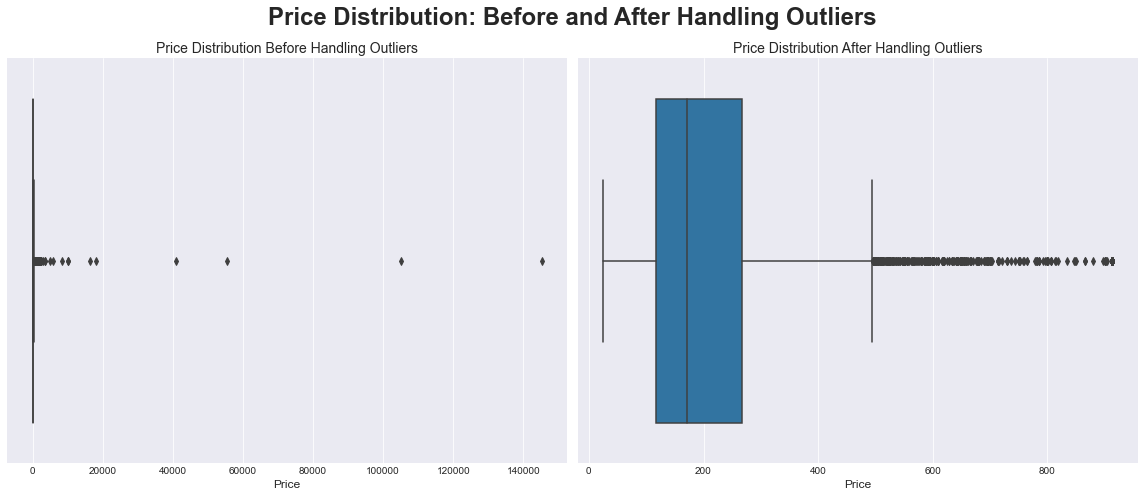

In [36]:
# Function to handle price outliers
def handle_price_outliers(df):
    """
    Handles price outliers in the train dataframe by capping the values.
    Args:
        df (pandas.DataFrame): DataFrame containing the 'price' column.
    Returns:
        pandas.DataFrame: DataFrame with capped price values.
    """
    Q1 = df['price'].quantile(0.1)
    Q3 = df['price'].quantile(0.9)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers
    df['price'] = np.where(df['price'] > upper_bound, upper_bound, df['price'])
    return df

# Make a copy of train_df before the changes
train_df_before = train_df.copy()

# Call the function to handle price outliers
train_df_after = handle_price_outliers(train_df.copy())

# Setting up the subplots
fig, axes = plt.subplots(1, 2, figsize=(16,7))

# Plotting 'price' before handling outliers
sns.boxplot(x=train_df_before['price'], ax=axes[0])
axes[0].set_title('Price Distribution Before Handling Outliers', fontsize=14)
axes[0].set_xlabel('Price', fontsize=12)

# Plotting 'price' after handling outliers
sns.boxplot(x=train_df_after['price'], ax=axes[1])
axes[1].set_title('Price Distribution After Handling Outliers', fontsize=14)
axes[1].set_xlabel('Price', fontsize=12)

plt.suptitle('Price Distribution: Before and After Handling Outliers', fontsize=24,fontweight='bold')
plt.tight_layout()

plt.show()

# Call the function to handle price outliers
train_df = handle_price_outliers(train_df)

### Section 2.5.2 : Handling Features with High Outlier Values

Boxplots are used to visually identify features in a dataset that have high outlier values. It achieves this by creating a grid of subplots using box plots. Each box plot represents a specific feature and provides a visual representation of the distribution of values, including any outliers. The resulting visualization helps in identifying features with high outlier values, enabling further analysis and consideration for appropriate data handling or preprocessing steps.

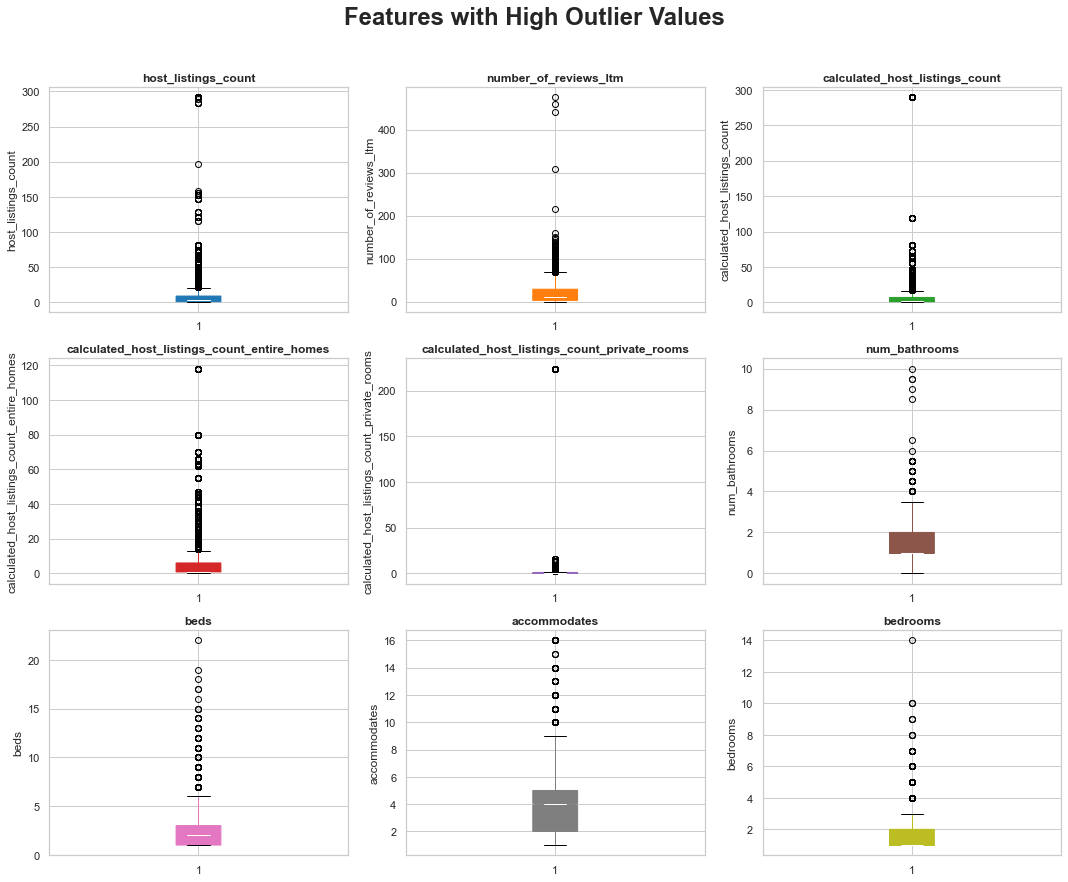

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

outlier_features = ['host_listings_count', 'number_of_reviews_ltm', 'calculated_host_listings_count',
                    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                    'num_bathrooms', 'beds', 'accommodates', 'bedrooms']

# Set the theme
sns.set_theme(style="whitegrid")

# Create the subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # increased size

# Flatten the axs array to make it easier to work with
axs = axs.flatten()

# Define a colormap
cmap = plt.get_cmap("tab10")

# Iterate over the outlier features and create boxplots in each subplot
for i, feature in enumerate(outlier_features):
    # Select the data for the current feature
    feature_data = train_df[feature]
    
    # Determine the subplot position
    ax = axs[i]
    
    # Create the boxplot with a color and a notch
    ax.boxplot(feature_data, notch=True, patch_artist=True,
               boxprops=dict(facecolor=cmap(i), color=cmap(i)),
               medianprops=dict(color="white"),
               whiskerprops=dict(color=cmap(i)))
    
    # Set the title for the subplot
    ax.set_title(feature, fontsize=12, fontweight='bold')  # increased font size and weight
    
    # Set the y-label
    ax.set_ylabel(feature)

# Adding a main title to the plot with some spacing
plt.suptitle("Features with High Outlier Values", fontsize=24, fontweight='bold', y=1.02)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


**Utilizing Winsorization in Data Preprocessing to Handle Outliers**

The function `handle_outliers()` is designed to manage outliers within a pandas DataFrame (df). Given a list of features suspected to contain outliers (outlier_features), and lower and upper limit values (lower_limit, upper_limit), the function implements the Winsorizing process on these selected features. Winsorization is a way to limit the impact of extreme values, or outliers, by capping them at a specific threshold, defined here by the lower and upper limits. In this case, features are only Winsorized if they exist in the DataFrame's columns, ensuring the function doesn't try to handle non-existent features. After the winsorization process, the function returns a new DataFrame where the specified features have been adjusted, thereby limiting the influence of their outliers. This helps to stabilize the data and make subsequent analyses more reliable. For example, this function is used on a DataFrame (train_df) with specific features like 'host_listings_count', 'number_of_reviews_ltm', etc., setting both lower and upper limits to 0.02.

In [38]:
import numpy as np
from scipy.stats.mstats import winsorize

def handle_outliers(df, outlier_features, lower_limit, upper_limit):
    """
    Winsorizes specified outlier features in a DataFrame to limit the impact of outliers.
    
    Args:
        df (pandas.DataFrame): DataFrame containing the data.
        outlier_features (list): List of features that have outliers.
        lower_limit (float): Lower limit for winsorization.
        upper_limit (float): Upper limit for winsorization.
    
    Returns:
        pandas.DataFrame: DataFrame with winsorized outlier features.
    """
    df_no_outlier = df.copy()

    valid_features = [feature for feature in outlier_features if feature in df.columns]

    for feature in valid_features:
        df_no_outlier[feature] = winsorize(df_no_outlier[feature], limits=(lower_limit, upper_limit))

    return df_no_outlier

outlier_features = [
    'host_listings_count', 
    'number_of_reviews_ltm', 
    'calculated_host_listings_count', 
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 
    'num_bathrooms', 
    'beds', 
    'accommodates', 
    'bedrooms'
]

lower_limit = 0.02
upper_limit = 0.02

train_df = handle_outliers(train_df, outlier_features, lower_limit, upper_limit)

The decision to set both the lower and upper limits for the **Winsorization** process at **0.02** was made to effectively minimize the influence of extreme outliers, which could skew data analysis, while preserving significant data that contribute to meaningful predictions. This choice reflects a balance between data cleaning and data integrity, with the threshold selected to cap the most extreme 2% of the data values on either end of the distribution. This approach acknowledges that outliers may often result from errors, unusual conditions, or anomalies, but also that they may sometimes represent important, albeit rare, information. Therefore, by selecting a limit of **0.02**, ***96%*** of the original data remains untouched, maintaining the majority of the original variance and valuable information, while the most drastic outliers are mitigated.

---
## Section 2.6: Exploratory Data Analysis

### Exploring Feature Relevance 
This code below performs an exploratory data analysis to assess the relevance of features in predicting the target variable. It employs three different methods - feature importance, mutual information, and correlation - to assess the relevance of features. By combining these methods and calculating ranks based on their results, it aims to identify the least relevant features in a more comprehensive manner. This approach helps prevent bias from a single model and compensates for the limitations of each individual method, resulting in a more robust evaluation of feature relevance.

In [39]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_importance(df, target, features):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df[features], df[target])
    importances = rf.feature_importances_
    return pd.DataFrame({'Feature': features, 'Importance': importances})

def calculate_mutual_info(df, target, features):
    mutual_info = mutual_info_regression(df[features], df[target])
    return pd.DataFrame({'Feature': features, 'Mutual Information': mutual_info})

def calculate_corr(df, target):
    corr_df = df.corr()[target][:-1] # Exclude the target variable itself
    return corr_df.reset_index().rename(columns = {'index':'Feature', target:'Correlation'})

def calculate_rank(df):
    df['Importance Rank'] = df['Importance'].rank(ascending=False)
    df['MI Rank'] = df['Mutual Information'].rank(ascending=False)
    df['Correlation Rank'] = df['Correlation'].abs().rank(ascending=False)
    df['Total Rank'] = df['Importance Rank'] + df['MI Rank'] + df['Correlation Rank']
    return df


target = 'price'
features = [col for col in train_df.columns if col != target]

importance_df = calculate_importance(train_df, target, features)
mutual_info_df = calculate_mutual_info(train_df, target, features)
corr_df = calculate_corr(train_df, target)

feature_df = pd.merge(importance_df, mutual_info_df, on='Feature')
feature_df = pd.merge(feature_df, corr_df, on='Feature')
feature_df = calculate_rank(feature_df)

#least_relevant = feature_df.sort_values('Total Rank', ascending=False).head(10)
#most_relevant = feature_df.sort_values('Total Rank', ascending=True).head(10)
least_relevant = feature_df.nlargest(5, 'Total Rank').reset_index(drop=True)
most_relevant = feature_df.nsmallest(5, 'Total Rank').reset_index(drop=True)

The `least_relevant` and `most_relevant` DataFrames represent subsets of features that are considered the least relevant and most relevant, respectively, based on their importance, mutual information, and correlation values.. Each row in the DataFrame corresponds to a specific feature and includes the following columns:

- `Feature`: Name of the feature
- `Importance`: Importance value indicating the relevance of the feature obtained from a random forest model
- `Mutual Information`: Mutual information score representing the amount of information the feature provides about the target variable
- `Correlation`: Correlation coefficient indicating the linear relationship between the feature and the target variable
- `Importance Rank`: Rank of the feature based on its importance value, with a higher rank indicating lower importance
- `MI Rank`: Rank of the feature based on its mutual information score, with a higher rank indicating lower information
- `Correlation Rank`: Rank of the feature based on its correlation coefficient, with a higher rank indicating lower correlation
- `Total Rank`: Sum of the importance rank, MI rank, and correlation rank, providing an overall ranking of the feature's relevance

This DataFrame provides insights into the least relevant features and their respective ranks, allowing for analysis and consideration of potential feature removal or optimization strategies.

In [40]:
# Displaying the Top 5 most relevant features based on the three methods
most_relevant.head()

,Feature,Importance,Mutual Information,Correlation,Importance Rank,MI Rank,Correlation Rank,Total Rank
0,bedrooms,0.288900,0.263903,0.588846,1.0,5.0,1.0,7.0
1,accommodates,0.046043,0.331663,0.581447,4.0,2.0,2.0,8.0
2,room_type_Private room,0.031625,0.204201,-0.337732,6.0,10.0,5.0,21.0
3,num_bathrooms,0.076773,0.179407,0.482957,2.0,18.0,4.0,24.0
4,beds,0.007319,0.220260,0.528243,30.0,8.0,3.0,41.0


In [41]:
# Displaying the Top 5 least relevant features based on the three methods
least_relevant.head()

,Feature,Importance,Mutual Information,Correlation,Importance Rank,MI Rank,Correlation Rank,Total Rank
0,phone,1.528545e-08,0.000000,0.011653,68.0,67.5,64.0,199.5
1,host_has_profile_pic,2.530363e-05,0.002649,-0.011947,67.0,63.0,63.0,193.0
2,calculated_host_listings_count_shared_rooms,8.063724e-04,0.000113,-0.032633,63.0,66.0,54.0,183.0
3,local_government_area_Stonnington,1.371110e-03,0.000736,-0.020510,56.0,65.0,59.0,180.0
4,local_government_area_Port Phillip,9.901232e-04,0.012051,0.019433,60.0,54.0,61.0,175.0


**Decision Against Dropping Less Relevant Features:**

After evaluating the relevance of features using methods like Random Forest feature importance, mutual information, and correlation matrix, we identified several features that seemed to be less relevant. However, we decided not to drop these features from our dataset. The reasoning behind this decision is that feature importance can vary and carry a degree of randomness each time the analysis is run. Consequently, the set of features deemed 'least important' could change with each run of the notebook. Given this inherent variability, we opted not to exclude these seemingly less relevant features from our dataset to ensure code reproducibility.

In [42]:
least_relevant['Feature']
## Drop the least relevant features from train_df
#train_df.drop(columns=least_relevant['Feature'], inplace=True)
#test_df.drop(columns=least_relevant['Feature'], inplace=True)

0                                          phone
1                           host_has_profile_pic
2    calculated_host_listings_count_shared_rooms
3              local_government_area_Stonnington
4             local_government_area_Port Phillip
Name: Feature, dtype: object

**Identifying Top Correlated Features with Price:**

This code calculates the correlation matrix between the features and the target variable (price). It then selects the top 10 most positively and negatively correlated features with price and visualizes them using a bar plot. The purpose of this code is to gain insight into the relationship between these selected features and the prices, providing an understanding of their correlation patterns.

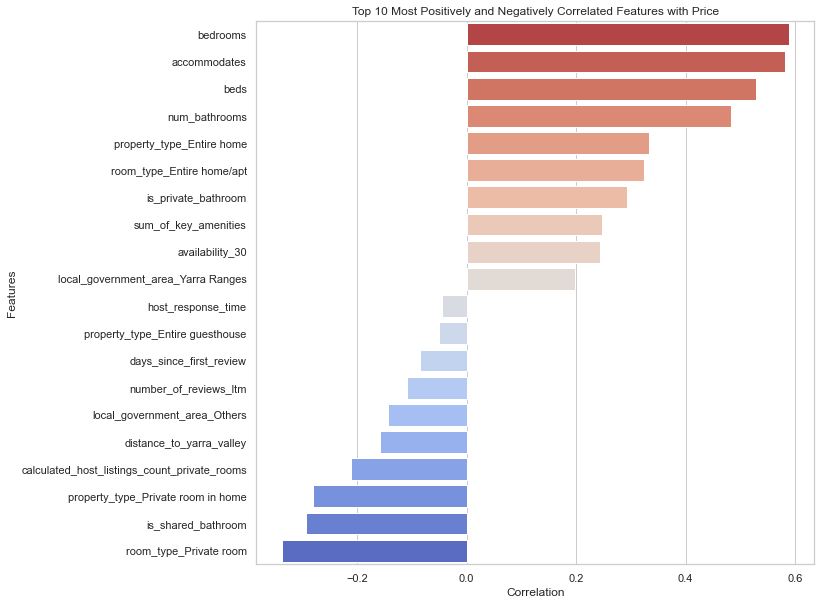

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Select the correlations for the target variable and sort them in descending order
target_corr = corr_matrix['price'].sort_values(ascending=False)

# Select the top 10 most positively correlated features and the top 10 most negatively correlated features
top10_positive_corr = target_corr.head(11).drop('price')
top10_negative_corr = target_corr.tail(10)

# Combine the selected features into a single DataFrame
top10_corr = pd.concat([top10_positive_corr, top10_negative_corr], axis=0)

# Create a bar plot to visualize the correlations
plt.figure(figsize=(10, 10))
sns.barplot(y=top10_corr.index, x=top10_corr.values, palette='coolwarm_r')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Top 10 Most Positively and Negatively Correlated Features with Price')
plt.show()

### Observations and Findings of Exploratory Data Analysis

From the exploratory data analysis (EDA) conducted, some key observations and findings emerged regarding the dataset. A significant relationship between specific features and the price was revealed, offering valuable insights that might guide future modeling and prediction processes.

- Positive Correlations: The most significant positively correlated variables were 'bedrooms', 'accommodates', 'beds', 'num_bathrooms', and 'property_type_Entire home'. The higher correlation values for these features suggest that as these variables increase, the price also tends to increase. In particular, 'bedrooms' and 'accommodates' had a substantial correlation with the price, suggesting that these features are key factors influencing the price.

- Negative Correlations: The variables 'room_type_Private room', 'is_shared_bathroom', 'property_type_Private room in home', 'calculated_host_listings_count_private_rooms', and 'distance_to_yarra_valley' showed a significant negative correlation with the price. This finding suggests that an increase in these variables might contribute to a decrease in the price.

Relevance Analysis: To further examine the relevance of the data, three methods were applied: the random forest feature importance, the correlation matrix, and mutual information.

- Most Relevant Features: The 'accommodates' and 'bedrooms' features were found to be most relevant, ranking highly across all three methods. The features 'room_type_Private room', 'num_bathrooms', and 'beds' were also important, but they had some inconsistencies across the different methods, suggesting the need for a balanced view of their relevance.

- Least Relevant Features: Conversely, the least relevant features in the dataset included 'host_has_profile_pic', 'phone', 'local_government_area_Stonnington', 'calculated_host_listings_count_shared_rooms', and 'email'. These features had low rankings across all three methods, suggesting they may not contribute significantly to the model's predictive power.

In conclusion, these findings from the EDA suggest certain features significantly impact price, and these should be prioritized in future modeling. Meanwhile, less relevant features could potentially be omitted to simplify the model and reduce the risk of overfitting

--- 
## <u>3. Fit and tune a forecasting model/Submit predictions/Report score and ranking</u>

### Section 3.1: Building the Model
The first step is to split the training data into separate sets for training and validation. This allows us to evaluate how our model performs on unseen data. The code below accomplishes this. The commented-out code in this section is for data normalization. StandardScaler standardizes features by removing the mean and scaling to unit variance. This is currently commented out and not included in this iteration because standardizing the dataset didn't improve our predictions.

In [44]:
# Feature Selection has been commented out because it didn't improve the results
## Create a StandardScaler instance
#scaler = StandardScaler()
#
## Fit the scaler on the training data (excluding 'price') and transform it
#train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df.drop('price', axis=1)), 
#                               columns=train_df.columns.drop('price'))
#
## Transform the test data with the same scaler
#test_df_scaled = pd.DataFrame(scaler.transform(test_df), 
#                              columns=test_df.columns)
#
## Add back the 'price' column to the scaled training data
#train_df_scaled['price'] = train_df['price']

In [45]:
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

# Separate features and target from the training data
features = train_df.drop('price', axis=1)
target = train_df['price']

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

### Section 3.2: Model Fitting and Hyperparameter Tuning

The next step involves fitting the model and tuning its hyperparameters. Hyperparameters are parameters that are not learned from the data and need to be set before training. GridSearchCV is used for this purpose. It performs an exhaustive search over specified parameter values for an estimator.

The code below also introduces several types of regression models, including Decision Tree, Random Forest, and Gradient Boosting. Each model's performance is evaluated using Root Mean Square Error (RMSE) and R-squared (R2). After the results are obtained from the Grid Search, the hyperparameter tuning was also commented out. Although GridSearch is beneficial in optimizing a model's hyperparameters, it is computationally expensive and takes a significant amount of time to run. As a result, the optimal hyperparameters found during an initial GridSearch run are directly used in the final model.

In [46]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_squared_error, r2_score, make_scorer
#from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor
#import numpy as np
#
## Define a custom scoring function
#def rmse(y_true, y_pred):
#    return np.sqrt(mean_squared_error(y_true, y_pred))
#
## Create a scorer to be used in GridSearchCV
#rmse_scorer = make_scorer(rmse, greater_is_better=False)
#
## Define a random state for reproducibility
#random_state = 42
#
## Define hyperparameter grids for each model
#param_grids = [
#    
#    {
#        'name': 'Linear Regression',
#        'estimator': LinearRegression(),
#        'params': {
#            'fit_intercept': [True, False],
#            'normalize': [True, False]
#        }
#    },
#    {
#        'name': 'Decision Tree',
#        'estimator': DecisionTreeRegressor(random_state=random_state),
#        'params': {
#            'max_depth': [3, 5, 10, None],
#            'min_samples_leaf': [1, 2, 5]
#        }
#    },
#    {
#        'name': 'Random Forest',
#        'estimator': RandomForestRegressor(random_state=random_state),
#        'params': {
#            'n_estimators': [400, 1000, 2000, 5000],
#            'max_depth': [None, 20, 30],
#            'min_samples_split': [2, 3, 4],
#            'min_samples_leaf': [1, 2, 3],
#            'max_features': ['sqrt', 'log2', None]
#        }
#    },
#    {
#        'name': 'Gradient Boosting',
#        'estimator': GradientBoostingRegressor(random_state=random_state),
#        'params': {
#            'n_estimators': [50, 100, 200, 1000, 2000],
#            'learning_rate': [0.01, 0.05, 0.1, 0.2],
#            'max_depth': [3, 5, 7]
#        }
#    },
#    {
#         'name': 'MLP',
#         'estimator': MLPRegressor(random_state=random_state),
#         'params': {
#             'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (100, 50)],
#             'activation': ['relu', 'logistic', 'tanh'],
#             'solver': ['adam', 'sgd'],
#             'alpha': [0.0001, 0.001, 0.01, 0.1],
#             'learning_rate': ['constant', 'invscaling', 'adaptive'],
#             'learning_rate_init': [0.001, 0.01, 0.1]
#         }
#     }, 
#]
#
## Run each model one by one
#for model in param_grids:
#    print(f"\n{model['name']}:")
#
#    # Grid search with cross-validation
#    grid = GridSearchCV(model['estimator'], model['params'], cv=5, scoring=rmse_scorer, n_jobs=-1)
#    grid.fit(X_train, y_train)
#
#    # Print out the best parameters
#    print(f"Best parameters: {grid.best_params_}")
#    
#    # Calculate metrics for training set
#    y_pred_train = grid.predict(X_train)
#    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}")
#    print(f"Train R2: {r2_score(y_train, y_pred_train)}")
#
#    # Calculate metrics for validation set
#    y_pred_val = grid.predict(X_val)
#    print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_val))}")
#    print(f"Validation R2: {r2_score(y_val, y_pred_val)}")
#

### Section 3.3: Building the Final Model

Once the hyperparameters have been tuned and a final model has been chosen, it is time to construct the model and train it using the complete dataset. This step guarantees that our model can acquire as much knowledge as possible from the data. After opting for the Random Forest model and determining the optimal hyperparameters, we proceed to build and train the final model using the entire dataset. 

In [47]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate and train RandomForestRegressor
random_forest_reg = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=1000,random_state = 42)
random_forest_reg.fit(features, target)

# Predict prices in the test dataset
test_predictions = random_forest_reg.predict(test_df)

### Section 3.4: Generating and Submitting Predictions

After the final model is built and trained, the next step is to generate predictions on the test dataset. These predictions can then be submitted to Kaggle. The code below creates a DataFrame with these predictions and writes it to a CSV file for submission.

In [48]:
# Create a DataFrame with the ID and price columns
submission_df = pd.DataFrame({'ID': range(7000, 7000 + len(test_predictions)), 'price': test_predictions})
# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

### Section 4.5: Reporting Performance and Reflection

### Best Score

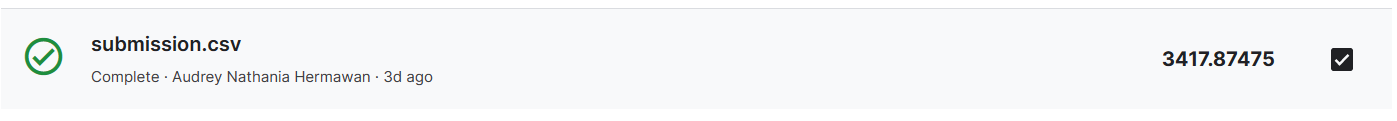

### Chosen Score
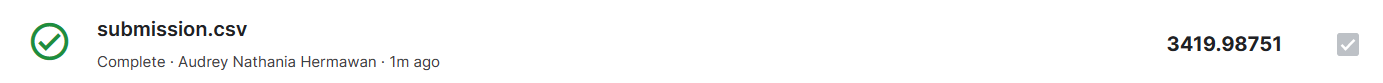

Our final submission achieved an RMSE score in the range of 3419.98751. While we did achieve a higher ranking with a lower RMSE score of 3417.87475 in a different iteration, we chose to proceed with the model in this Jupyter notebook project due to its thorough and methodical approach towards every step of the machine learning pipeline.

This project utilized a range of essential machine learning techniques such as data cleaning, feature extraction and selection, dimensionality reduction (by removing multicollinearity), enhancing data quality by imputing missing data, properly encoding categorical variables, detecting and handling outliers, and conducting an exploratory data analysis of features to discover relationships with the 'price' target variable. This analysis was done using different methods including mutual information, Random Forest feature importance, and a correlation matrix.

We further explored different regression models, tuned their hyperparameters, and ultimately fitted the final model to make predictions. Our focus throughout this project was on the process rather than solely on the final score.

Although there are certain practices which could have potentially increased our score - such as concatenating the test dataset with the train dataset for missing value imputation - we intentionally refrained from doing so. Such practices can lead to data leakage, where information from the outside of our training dataset is used, which can result in overoptimistic performance estimates and could undermine the fundamental purpose of predictive modeling. 

In essence, our priority in this project was to adhere to sound data science principles rather than solely pursuing a higher score through any means necessary.

---